# Multi-layer neural networks
## Feed-forward model
### Single-layer activation

In [1]:
import numpy as np
from typing import Literal, Callable

# Define supported activation function types for type safety
ActivationType = Literal["linear", "tanh", "sigmoid", "relu", "jump"]

# Neural network activation functions
sigmoid: Callable[[np.ndarray], np.ndarray] = lambda x: 1 / (1 + np.exp(-x))
relu: Callable[[np.ndarray], np.ndarray] = lambda x: np.maximum(0, x)
jump: Callable[[np.ndarray], np.ndarray] = lambda x: np.where(x > 0, 1.0, 0.0)


def activate_layer(
    input_data: np.ndarray,
    weight_matrix: np.ndarray,
    bias_vector: np.ndarray,
    activation: ActivationType = "tanh",
) -> np.ndarray:
    """
    Apply layer transformation for single input or batch.

    Args:
        input_data: Input data of shape (input_size,) for single input or
                   (input_size, batch_size) for batch input
        weight_matrix: Weight matrix of shape (output_size, input_size)
        bias_vector: Bias vector of shape (output_size,)
        activation: Activation function name (default: "tanh")

    Returns:
        Layer output of shape (output_size,) for single input or
        (output_size, batch_size) for batch input

    Raises:
        ValueError: If activation function is not supported
    """
    # Compute linear transformation with dimension-aware bias handling
    if input_data.ndim == 1:
        # Single input: standard matrix-vector multiplication
        z: np.ndarray = weight_matrix @ input_data + bias_vector
    else:
        # Batch input: broadcast bias across batch dimension
        z = weight_matrix @ input_data + bias_vector[:, np.newaxis]

    # Apply specified activation function
    if activation == "linear":
        return z
    elif activation == "tanh":
        return np.tanh(z)
    elif activation == "sigmoid":
        return sigmoid(z)
    elif activation == "relu":
        return relu(z)
    elif activation == "jump":
        return jump(z)
    else:
        raise ValueError(f"Unsupported activation function: {activation}")

### Multi-layer activation

In [2]:
import numpy as np
from typing import Sequence, List


def activate_network(
    input_data: np.ndarray,
    weight_matrices: Sequence[np.ndarray],
    bias_vectors: Sequence[np.ndarray],
    activation: ActivationType = "tanh",
) -> List[np.ndarray]:
    """
    Forward pass through entire network.

    Args:
        input_data: Input data of shape (input_size,) or (batch_size, input_size)
        weight_matrices: Sequence of weight matrices, each of shape (output_size_i, input_size_i)
        bias_vectors: Sequence of bias vectors, each of shape (output_size_i,)
        activation: Activation function name (default: "tanh")

    Returns:
        List of layer outputs including input layer, each of shape matching the layer dimensions

    Raises:
        ValueError: If number of weight matrices and bias vectors don't match
    """
    # Validate network architecture consistency
    num_layers = len(weight_matrices)
    if num_layers != len(bias_vectors):
        raise ValueError("The number of weight matrices and bias vectors do not match.")

    # Perform forward propagation through all layers
    activated_layers: List[np.ndarray] = [input_data]
    for weight_matrix, bias_vector in zip(weight_matrices, bias_vectors):
        layer_output = activate_layer(
            activated_layers[-1], weight_matrix, bias_vector, activation
        )
        activated_layers.append(layer_output)

    return activated_layers


def network_output(
    input_data: np.ndarray,
    weight_matrices: Sequence[np.ndarray],
    bias_vectors: Sequence[np.ndarray],
    activation: ActivationType = "tanh",
) -> np.ndarray:
    """
    Get final network output.

    Args:
        input_data: Input data of shape (input_size,) or (batch_size, input_size)
        weight_matrices: Sequence of weight matrices, each of shape (output_size_i, input_size_i)
        bias_vectors: Sequence of bias vectors, each of shape (output_size_i,)
        activation: Activation function name (default: "tanh")

    Returns:
        Final layer output of shape (output_size,) or (batch_size, output_size)
    """
    # Extract final layer output from complete forward pass
    return activate_network(input_data, weight_matrices, bias_vectors, activation)[-1]

### Output test

In [3]:
import numpy as np

# Define multi-layer network architecture: 2 -> 4 -> 2
dims = [2, 4, 2]

# Initialize random network parameters with fixed seed
np.random.seed(42)
bias_vectors = [np.random.randn(dims[i]) for i in range(1, len(dims))]
weight_matrices = [np.random.randn(dims[i], dims[i - 1]) for i in range(1, len(dims))]

# Test single input forward pass
single_input = np.array([0.2, 0.4])
single_output = network_output(
    single_input, weight_matrices, bias_vectors, activation="tanh"
)

# Test batch input processing
batch_input = np.array([[0.2, 0.1], [0.4, 0.5]])
batch_output = network_output(
    batch_input, weight_matrices, bias_vectors, activation="sigmoid"
)

# Display results comparing single vs batch processing
print(f"Input vector:\n {single_input}")
print(f"Output using tanh activation:\n {single_output}")
print(f"Input batch:\n {batch_input}")
print(f"Output batch using sigmoid activation:\n {batch_output}")

Input vector:
 [0.2 0.4]
Output using tanh activation:
 [-0.94316984 -0.52224503]
Input batch:
 [[0.2 0.1]
 [0.4 0.5]]
Output batch using sigmoid activation:
 [[0.10019244 0.09995236]
 [0.28717069 0.28491365]]


### Output visualization

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.figure import Figure
from typing import Sequence, List

# Configure matplotlib for publication-quality plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 300


def visualize_output(
    weight_matrices: Sequence[np.ndarray],
    bias_vectors: Sequence[np.ndarray],
    activation: str = "tanh",
    input_range: Sequence[float] = [-5.0, 5.0, -5.0, 5.0],
    points: int = 300,
) -> Figure:
    """
    Visualize 2D network output as heatmaps.

    Args:
        weight_matrices: Sequence of weight matrices for the network layers
        bias_vectors: Sequence of bias vectors for the network layers
        activation: Activation function name (default: "tanh")
        input_range: Input range as [x1_min, x1_max, x2_min, x2_max] (default: [-5, 5, -5, 5])
        points: Grid resolution for visualization (default: 300)

    Returns:
        Matplotlib figure containing the heatmap plots

    Raises:
        ValueError: If network is not 2D input -> 2D output or architecture is inconsistent
    """
    # Validate network is 2D input to 2D output
    input_dim = weight_matrices[0].shape[1]
    output_dim = weight_matrices[-1].shape[0]
    if input_dim != 2:
        raise ValueError("The input is not two-dimensional.")
    elif output_dim != 2:
        raise ValueError("The output is not two-dimensional.")

    # Validate weight and bias dimensions are consistent
    network_dims = [W.shape[0] for W in weight_matrices]
    bias_dims = [b.shape[0] for b in bias_vectors]
    if network_dims != bias_dims:
        raise ValueError("Weight and bias dimensions do not match.")

    # Create 2D input grid for visualization
    x1_range: np.ndarray = np.linspace(input_range[0], input_range[1], points)
    x2_range: np.ndarray = np.linspace(input_range[2], input_range[3], points)

    X1: np.ndarray
    X2: np.ndarray
    X1, X2 = np.meshgrid(x1_range, x2_range)
    input_points: np.ndarray = np.vstack([X1.ravel(), X2.ravel()])

    # Compute network outputs across the entire grid
    outputs_raw: np.ndarray = network_output(
        input_points, weight_matrices, bias_vectors, activation="tanh"
    )
    outputs: List[np.ndarray] = [
        outputs_raw[0].reshape(X1.shape),
        outputs_raw[1].reshape(X2.shape),
    ]
    titles: List[str] = ["Output 1", "Output 2"]

    # Create side-by-side heatmap visualization
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, output, title in zip(axes, outputs, titles):
        im = ax.imshow(output, extent=input_range, origin="lower", cmap="copper")
        ax.set_title(title)
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.close()
    return fig

### Output visualization test

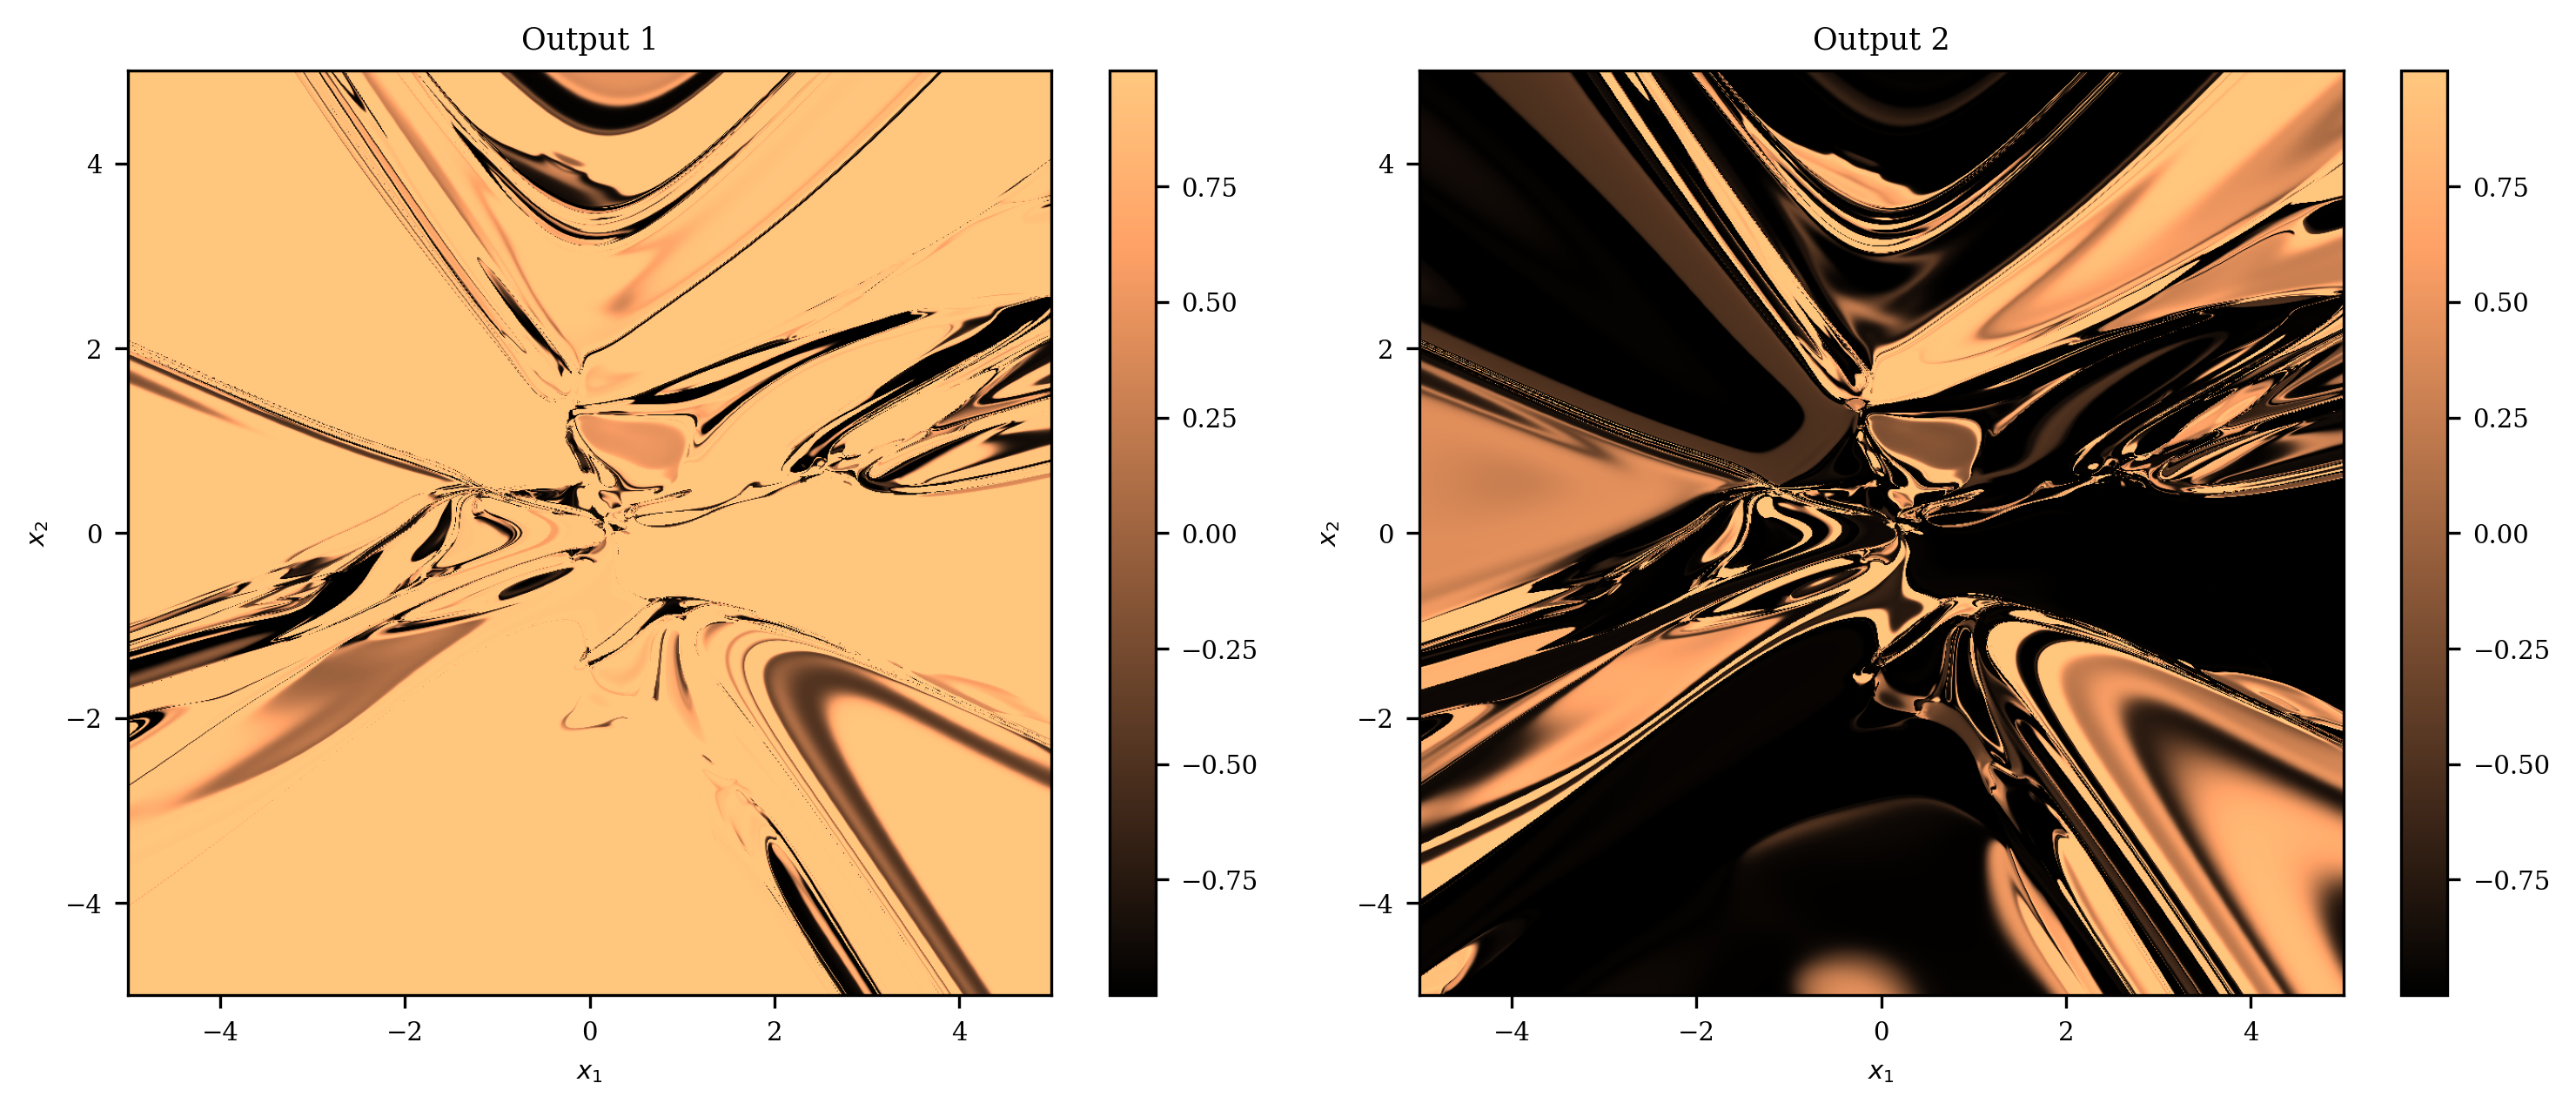

In [5]:
import numpy as np

# Define deep network architecture parameters
num_layers = 15
layer_width = 15
input_dim, output_dim = 2, 2

# Build network dimensions: input -> hidden layers -> output
dims = [input_dim] + [layer_width] * num_layers + [output_dim]

# Initialize random network parameters with fixed seed
np.random.seed(42)
bias_vectors = [np.random.randn(dims[i]) for i in range(1, len(dims))]
weight_matrices = [np.random.randn(dims[i], dims[i - 1]) for i in range(1, len(dims))]

# Generate high-resolution visualization of network output
visualize_output(weight_matrices, bias_vectors, points=1000)

## Alternative implementation using JAX vectorization

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from typing import Literal, Callable, Sequence

# Configure matplotlib for publication-quality plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 300

# Type aliases for cleaner function signatures
ActivationType = Literal["linear", "tanh", "sigmoid", "relu", "jump"]

# JAX-compatible activation functions
sigmoid: Callable[[jnp.ndarray], jnp.ndarray] = lambda x: 1 / (1 + jnp.exp(-x))
relu: Callable[[jnp.ndarray], jnp.ndarray] = lambda x: jnp.maximum(0, x)
jump: Callable[[jnp.ndarray], jnp.ndarray] = lambda x: jnp.where(x > 0, 1.0, 0.0)


def activate_layer(
    input_vector: jnp.ndarray,
    weight_matrix: jnp.ndarray,
    bias_vector: jnp.ndarray,
    activation: ActivationType = "relu",
) -> jnp.ndarray:
    """
    Apply layer transformation with activation.

    Args:
        input_vector: Input vector of shape (input_size,)
        weight_matrix: Weight matrix of shape (output_size, input_size)
        bias_vector: Bias vector of shape (output_size,)
        activation: Activation function name

    Returns:
        Output vector of shape (output_size,)
    """
    # Compute linear transformation: z = Wx + b
    z = jnp.dot(weight_matrix, input_vector) + bias_vector

    # Apply specified activation function
    if activation == "linear":
        return z
    elif activation == "tanh":
        return jnp.tanh(z)
    elif activation == "sigmoid":
        return sigmoid(z)
    elif activation == "relu":
        return relu(z)
    elif activation == "jump":
        return jump(z)
    else:
        raise ValueError(f"Unsupported activation function: {activation}")


def activate_network(
    input_data: jnp.ndarray,
    weight_matrices: Sequence[jnp.ndarray],
    bias_vectors: Sequence[jnp.ndarray],
    activation: ActivationType = "relu",
) -> list[jnp.ndarray]:
    """
    Forward pass through entire network.

    Args:
        input_data: Input data of shape (input_size,) or (batch_size, input_size)
        weight_matrices: Sequence of weight matrices, each of shape (output_size_i, input_size_i)
        bias_vectors: Sequence of bias vectors, each of shape (output_size_i,)
        activation: Activation function name

    Returns:
        List of layer outputs including input layer
    """
    # Validate network architecture consistency
    num_layers = len(weight_matrices)
    if num_layers != len(bias_vectors):
        raise ValueError("The number of weight matrices and bias vectors do not match.")

    # Perform forward propagation through all layers
    activated_layers: list[jnp.ndarray] = [input_data]
    for weight_matrix, bias_vector in zip(weight_matrices, bias_vectors):
        layer_output = activate_layer(
            activated_layers[-1], weight_matrix, bias_vector, activation
        )
        activated_layers.append(layer_output)

    return activated_layers


def network_output(
    input_data: jnp.ndarray,
    weight_matrices: Sequence[jnp.ndarray],
    bias_vectors: Sequence[jnp.ndarray],
    activation: ActivationType = "relu",
) -> jnp.ndarray:
    """
    Get final network output.

    Args:
        input_data: Input data of shape (input_size,) or (batch_size, input_size)
        weight_matrices: Sequence of weight matrices, each of shape (output_size_i, input_size_i)
        bias_vectors: Sequence of bias vectors, each of shape (output_size_i,)
        activation: Activation function name

    Returns:
        Final layer output of shape (output_size,) or (batch_size, output_size)
    """
    # Extract final layer output from complete forward pass
    return activate_network(input_data, weight_matrices, bias_vectors, activation)[-1]


# Vectorize network_output for efficient batch processing
# in_axes=(0, None, None, None) vectorizes over first arg, broadcasts others
_network_output_vectorized = jax.vmap(network_output, in_axes=(0, None, None, None))


def network_output_vectorized(
    input_data: jnp.ndarray,
    weight_matrices: Sequence[jnp.ndarray],
    bias_vectors: Sequence[jnp.ndarray],
    activation: ActivationType = "relu",
) -> jnp.ndarray:
    """
    Vectorized network output for batch processing.

    Args:
        input_data: Batch of input data of shape (batch_size, input_size)
        weight_matrices: Sequence of weight matrices for the network
        bias_vectors: Sequence of bias vectors for the network
        activation: Activation function name

    Returns:
        Batch of network outputs of shape (batch_size, output_size)
    """
    return _network_output_vectorized(
        input_data, weight_matrices, bias_vectors, activation
    )


def visualize_output_vectorized(
    weight_matrices: Sequence[jnp.ndarray],
    bias_vectors: Sequence[jnp.ndarray],
    activation: ActivationType,
    input_range: Sequence[float],
    resolution: int,
) -> Figure:
    """
    Visualize 2D network output as heatmaps.

    Args:
        weight_matrices: Sequence of weight matrices for the network
        bias_vectors: Sequence of bias vectors for the network
        activation: Activation function name
        input_range: Input range as [x1_min, x1_max, x2_min, x2_max]
        resolution: Grid resolution for visualization

    Returns:
        Matplotlib figure containing the heatmap plots

    Raises:
        ValueError: If network is not 2D input -> 2D output or architecture is inconsistent
    """
    # Validate network is 2D input to 2D output
    input_dim = weight_matrices[0].shape[1]
    output_dim = weight_matrices[-1].shape[0]
    if input_dim != 2:
        raise ValueError("The input is not two-dimensional.")
    elif output_dim != 2:
        raise ValueError("The output is not two-dimensional.")

    # Validate weight and bias dimensions are consistent
    network_dims = [W.shape[0] for W in weight_matrices]
    bias_dims = [b.shape[0] for b in bias_vectors]
    if network_dims != bias_dims:
        raise ValueError("Weight and bias dimensions do not match.")

    # Create 2D input grid for visualization
    x1_range: jnp.ndarray = jnp.linspace(input_range[0], input_range[1], resolution)
    x2_range: jnp.ndarray = jnp.linspace(input_range[2], input_range[3], resolution)
    x1_flat: jnp.ndarray
    x2_flat: jnp.ndarray
    x1_flat, x2_flat = jnp.meshgrid(x1_range, x2_range)

    # Prepare input for batch processing: shape (resolution², 2)
    input_points: jnp.ndarray = jnp.vstack([x1_flat.ravel(), x2_flat.ravel()]).T

    # Compute network outputs using vectorized function
    output_flat: jnp.ndarray = network_output_vectorized(
        input_points, weight_matrices, bias_vectors, activation
    ).T

    # Reshape outputs back to 2D grid for visualization
    outputs: list[jnp.ndarray] = [
        output_flat[0].reshape(resolution, resolution),
        output_flat[1].reshape(resolution, resolution),
    ]
    titles: list[str] = ["Output 1", "Output 2"]

    # Create side-by-side heatmap visualization
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, output, title in zip(axes, outputs, titles):
        im = ax.imshow(output, extent=input_range, origin="lower", cmap="copper")
        ax.set_title(title)
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.close()
    return fig

### Implementation using JAX: output test

In [7]:
import jax
import jax.numpy as jnp

# Define multi-layer network architecture: 2 -> 4 -> 2
dims = [2, 4, 2]

# Initialize network parameters using JAX random number generation
key = jax.random.PRNGKey(42)
key1, key2 = jax.random.split(key)
bias_vectors = [jax.random.normal(key1, shape=(dims[i],)) for i in range(1, len(dims))]
weight_matrices = [
    jax.random.normal(key2, shape=(dims[i], dims[i - 1])) for i in range(1, len(dims))
]

# Test single input forward pass
single_input = jnp.array([0.2, 0.4])
single_output = network_output(single_input, weight_matrices, bias_vectors, "tanh")

# Test vectorized batch processing
batch_input = jnp.array([[0.2, 0.1], [0.4, 0.5]])
batch_output = network_output_vectorized(
    batch_input, weight_matrices, bias_vectors, "sigmoid"
)

# Display results comparing single vs batch processing
print(f"Input vector:\n {single_input}")
print(f"Output using tanh activation:\n {single_output}")
print(f"Input batch:\n {batch_input}")
print(f"Output batch using sigmoid activation:\n {batch_output}")

Input vector:
 [0.2 0.4]
Output using tanh activation:
 [ 0.8581199 -0.9350885]
Input batch:
 [[0.2 0.1]
 [0.4 0.5]]
Output batch using sigmoid activation:
 [[0.6293202  0.13208292]
 [0.62637085 0.12689935]]


### Implementation using JAX: output visualization test

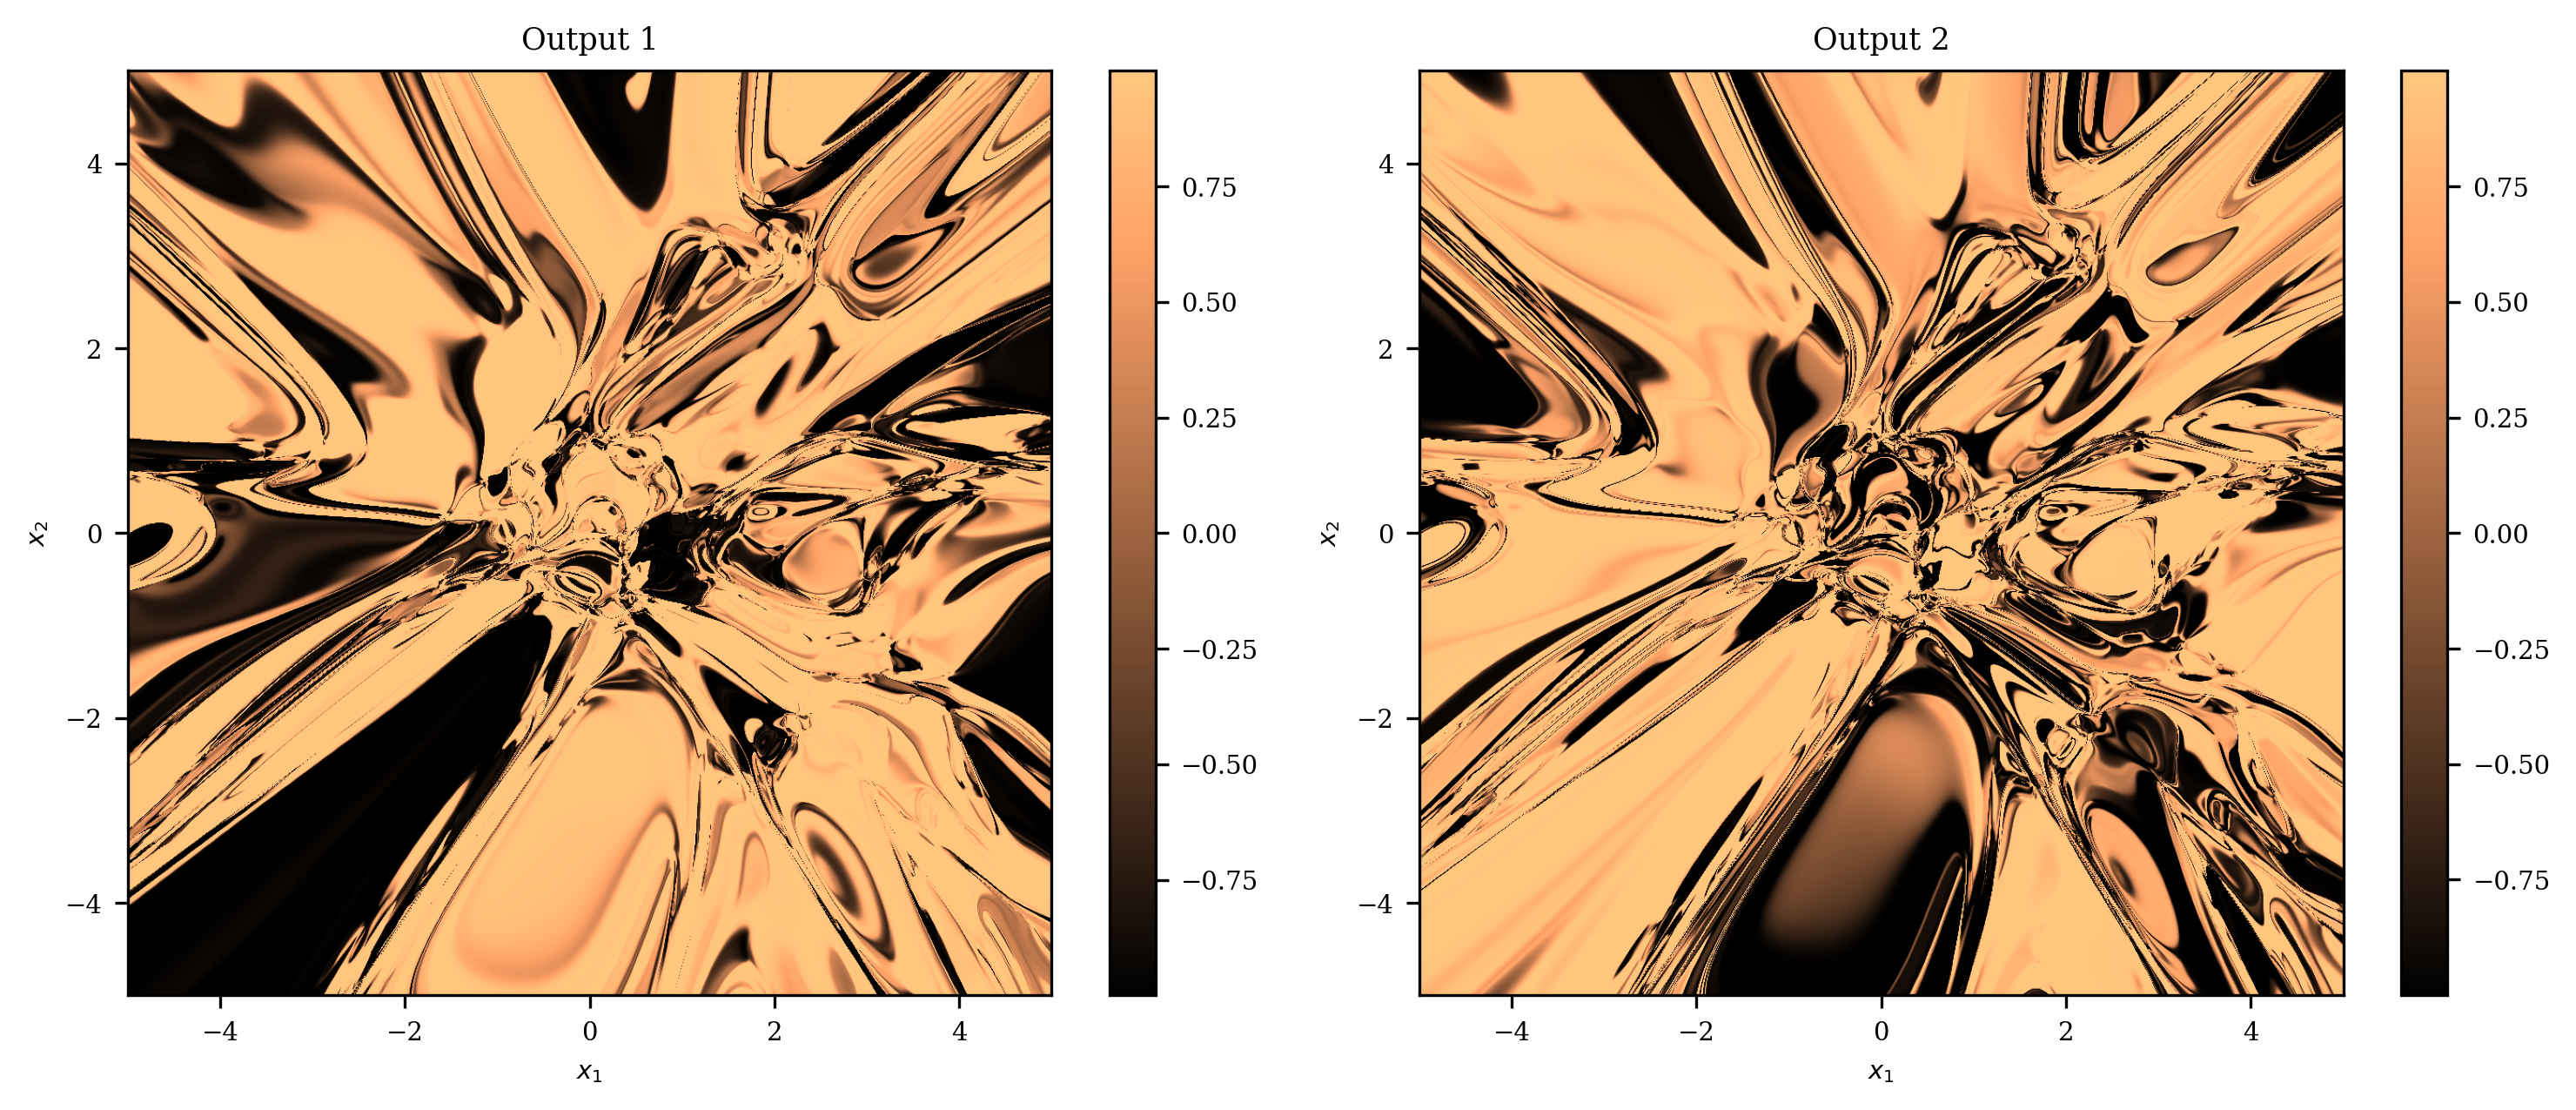

In [8]:
import jax

# Define deep network architecture parameters
num_layers = 15
layer_width = 15
input_dim, output_dim = 2, 2

# Build network dimensions: input -> hidden layers -> output
dims = [input_dim] + [layer_width] * num_layers + [output_dim]

# Initialize random network parameters using JAX
key = jax.random.PRNGKey(42)
key1, key2 = jax.random.split(key)
bias_vectors = [jax.random.normal(key1, shape=(dims[i],)) for i in range(1, len(dims))]
weight_matrices = [
    jax.random.normal(key2, shape=(dims[i], dims[i - 1])) for i in range(1, len(dims))
]

# Generate high-resolution visualization with vectorized computation
visualize_output_vectorized(
    weight_matrices, bias_vectors, "tanh", [-5.0, 5.0, -5.0, 5.0], 1000
)